In [1]:
x=2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
import pandas as pd
import multigrate as mtg
import multimil as mtm
from pathlib import Path
import shutil

from matplotlib import pyplot as plt
import scanpy as sc
import pandas as pd
import anndata as ad
import os
import random
import torch
import scvi
import numpy as np

[rank: 0] Global seed set to 0


In [63]:
adata = sc.read('../../pipeline/data/pp/mtg3_clean_healthy_covid_3_cond_embed.h5ad')
adata

AnnData object with n_obs × n_vars = 362426 × 16
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch'
    obsm: 'X_umap'

In [64]:
adata.obs['Status_on_day_collection_summary_cont'] = adata.obs['Status_on_day_collection_summary'].copy()
adata.obs['Status_on_day_collection_summary_cont'] = adata.obs['Status_on_day_collection_summary_cont'].str.replace('Healthy', '0')
adata.obs['Status_on_day_collection_summary_cont'] = adata.obs['Status_on_day_collection_summary_cont'].str.replace('Mild', '1')
adata.obs['Status_on_day_collection_summary_cont'] = adata.obs['Status_on_day_collection_summary_cont'].str.replace('Severe', '2')
adata.obs['Status_on_day_collection_summary_cont'] = adata.obs['Status_on_day_collection_summary_cont'].astype(float)

In [65]:
adata

AnnData object with n_obs × n_vars = 362426 × 16
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'Status_on_day_collection_summary_cont'
    obsm: 'X_umap'

In [66]:
adata = mtg.data.organize_multiome_anndatas(
            adatas = [[adata]],
        )

/tmp/ipykernel_3258110/3981741654.py:1: UserWarning: Column `.obs['group']` will be overwritten. Please save the original data in another column if needed.
  adata = mtg.data.organize_multiome_anndatas(


In [67]:
query = adata[adata.obs[f"split0"] == "val"].copy()
adata = adata[adata.obs[f"split0"] == "train"].copy()

In [68]:
idx = adata.obs['patient_id'].sort_values().index
adata = adata[idx].copy()

In [69]:
mtm.model.MILClassifier.setup_anndata(
    adata, 
    rna_indices_end=16,
    categorical_covariate_keys=['patient_id', 'Status_on_day_collection_summary'],
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [70]:
mil = mtm.model.MILClassifier(
            adata,
            # classification=['Status_on_day_collection_summary'],
            ordinal_regression=['Status_on_day_collection_summary'],
            # regression=['Status_on_day_collection_summary_cont'],
            patient_label='patient_id',
            # class_loss_coef=1.0,
            z_dim=16,
        )

The order for Status_on_day_collection_summary ordinal classes is: Index(['Healthy', 'Mild', 'Severe'], dtype='object'). If you need to change the order, please rerun setup_anndata and specify the correct order with the `ordinal_regression_order` parameter.


In [71]:
mil.module

MILClassifierTorch(
  (vae): MultiVAETorch(
    (cont_covariate_embeddings): Embedding(0, 16)
    (cont_covariate_curves): GeneralizedSigmoid()
    (encoder_0): MLP(
      (mlp): FCLayers(
        (fc_layers): Sequential(
          (Layer 0): Sequential(
            (0): Linear(in_features=16, out_features=128, bias=True)
            (1): None
            (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Dropout(p=0.2, inplace=False)
          )
          (Layer 1): Sequential(
            (0): Linear(in_features=128, out_features=16, bias=True)
            (1): None
            (2): LayerNorm((16,), eps=1e-05, elementwise_affine=False)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Dropout(p=0.2, inplace=False)
          )
        )
      )
    )
    (decoder_0): Decoder(
      (decoder): MLP(
        (mlp): FCLayers(
          (fc_layers): Sequential(
            (Layer 0): Sequential(
      

In [72]:
for classifier in mil.module.classifiers:
    print(torch.linalg.norm(classifier[0].mlp.fc_layers[0][0].weight, 2))

In [11]:
mil.train(
    lr=1e-5,
    batch_size=512, 
    max_epochs=2,
    # path_to_checkpoints='./checkpoints/',
    # save_checkpoint_every_n_epochs=2,
    # early_stopping_monitor='regression_loss_validation',
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/multimil/multimil/model/_mil.py:367: UserWarning: Setting early_stopping_monitor to 'regression_loss_validation' and early_stopping_mode to 'min' as regression is used.
  warnings.warn("Setting early_stopping_monitor to 'regression_loss_validation' and early_stopping_mode to 'min' as regression is used.")
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /lustre/groups/ml01/workspace/anastasia.litinets ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetsk

Epoch 2/2: 100%|██████████| 2/2 [00:10<00:00,  5.07s/it, loss=0.632, v_num=1]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 2/2: 100%|██████████| 2/2 [00:10<00:00,  5.46s/it, loss=0.632, v_num=1]


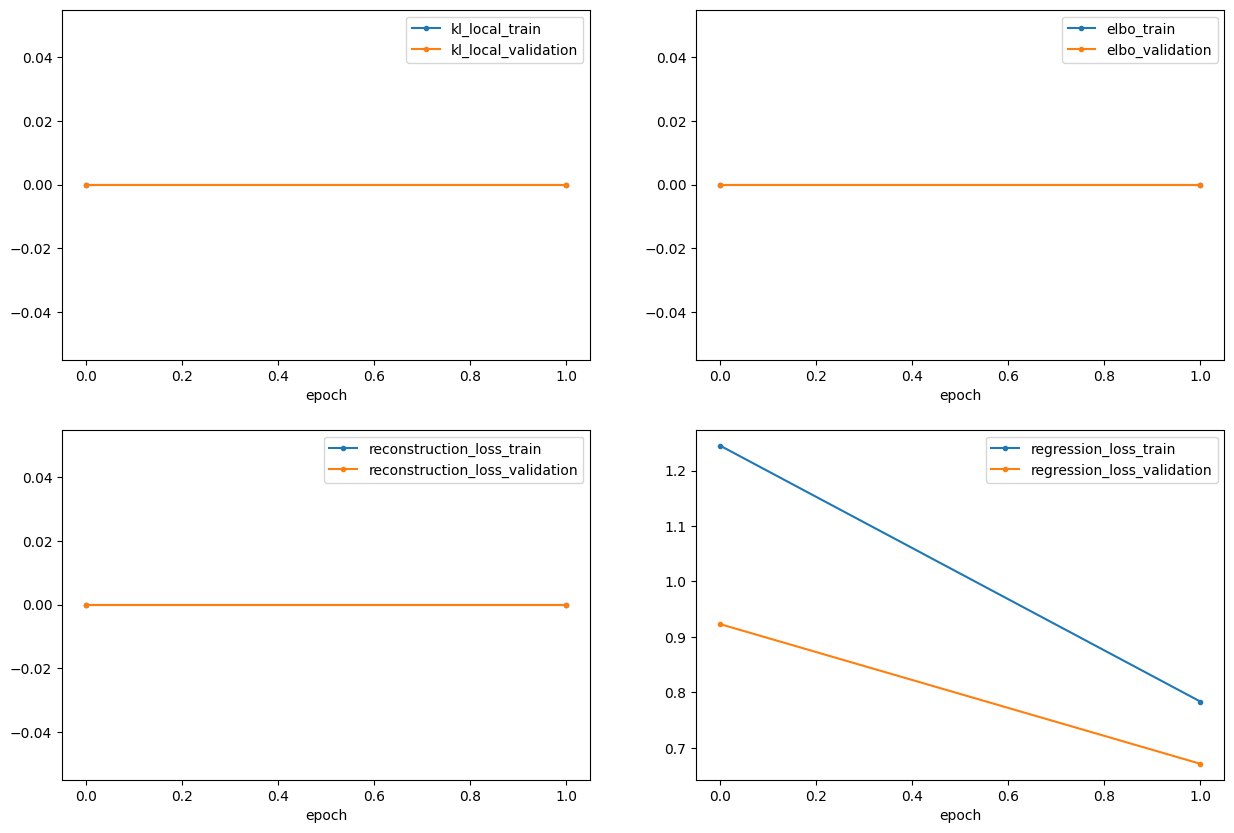

In [12]:
mil.plot_losses()

In [15]:
mil.get_model_output(batch_size=512)

In [16]:
adata

AnnData object with n_obs × n_vars = 309468 × 16
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'Status_on_day_collection_summary_cont', 'cell_attn', 'bags'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid', 'bag_regression_true', 'bag_regression_predictions'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'latent', 'regression_predictions'

In [19]:
mil.adata_manager.get_state_registry('extra_continuous_covs')['columns']

array(['Status_on_day_collection_summary_cont'], dtype=object)

In [46]:
idx = query.obs['patient_id'].sort_values().index
query = query[idx].copy()

In [47]:
new_model = mtm.model.MILClassifier.load_query_data(query, reference_model=mil)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


The order for Status_on_day_collection_summary ordinal classes is: Index(['Healthy', 'Mild', 'Severe'], dtype='object'). If you need to change the order, please rerun setup_anndata and specify the correct order with the `ordinal_regression_order` parameter.


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [49]:
new_model.is_trained_ = True
new_model.get_model_output(query, batch_size=512)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [50]:
query

AnnData object with n_obs × n_vars = 52958 × 16
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn', 'bags', 'predicted_Status_on_day_collection_summary'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid', 'bag_ord_regression_true_Status_on_day_collection_summary', 'bag_ord_regression_predictions_Status_on_day_collection_summary', 'bag_predicted_Status_on_day_collection_summary'
    obsm: '_scvi_extra_categorical_covs', 'latent', 'ord_regression_predictions_Status_on_day_collection_summary'

In [51]:
condition = 'Status_on_day_collection_summary'

In [53]:
from sklearn.metrics import classification_report
report = classification_report(query.obs[condition], query.obs[f"predicted_{condition}"], output_dict=True)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

In [54]:
report

{'Healthy': {'precision': 0.30456431535269707,
  'recall': 0.07401431884642533,
  'f1-score': 0.11908818041697088,
  'support': 19834.0},
 'Mild': {'precision': 0.474863932859695,
  'recall': 1.0,
  'f1-score': 0.6439427018043016,
  'support': 22859.0},
 'Severe': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 10265.0},
 'accuracy': 0.4593640243211602,
 'macro avg': {'precision': 0.2598094160707974,
  'recall': 0.35800477294880845,
  'f1-score': 0.2543436274070908,
  'support': 52958.0},
 'weighted avg': {'precision': 0.3190385451101847,
  'recall': 0.4593640243211602,
  'f1-score': 0.3225552549366428,
  'support': 52958.0}}